In [59]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters
import skimage.filters.rank
import skimage.segmentation
import skimage.measure
import skimage.transform
import glob
import random
import re
from numba import njit

# Image show

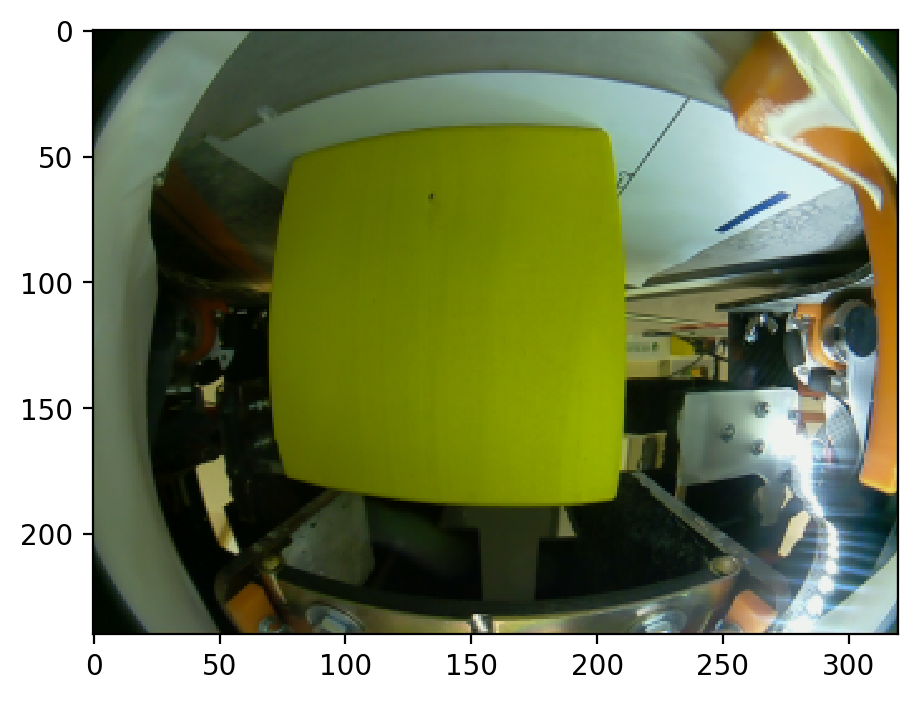

In [127]:
raw_img = cv2.cvtColor(cv2.imread("calibrate_imgs/10_0_2.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Undistorte image

In [128]:
K=np.array([[543.107811968841, 0.0, 630.7227631662455], [0.0, 540.0320855865099, 486.5749791589516], [0.0, 0.0, 1.0]])
D=np.array([[-0.05195582161040964], [-0.009477421485536482], [0.010893416415594874], [-0.005379345567357744]])
K1 = K.copy()
K1[:2] /= 4
K2 = K1.copy()
K2[:2, :2] /= 2

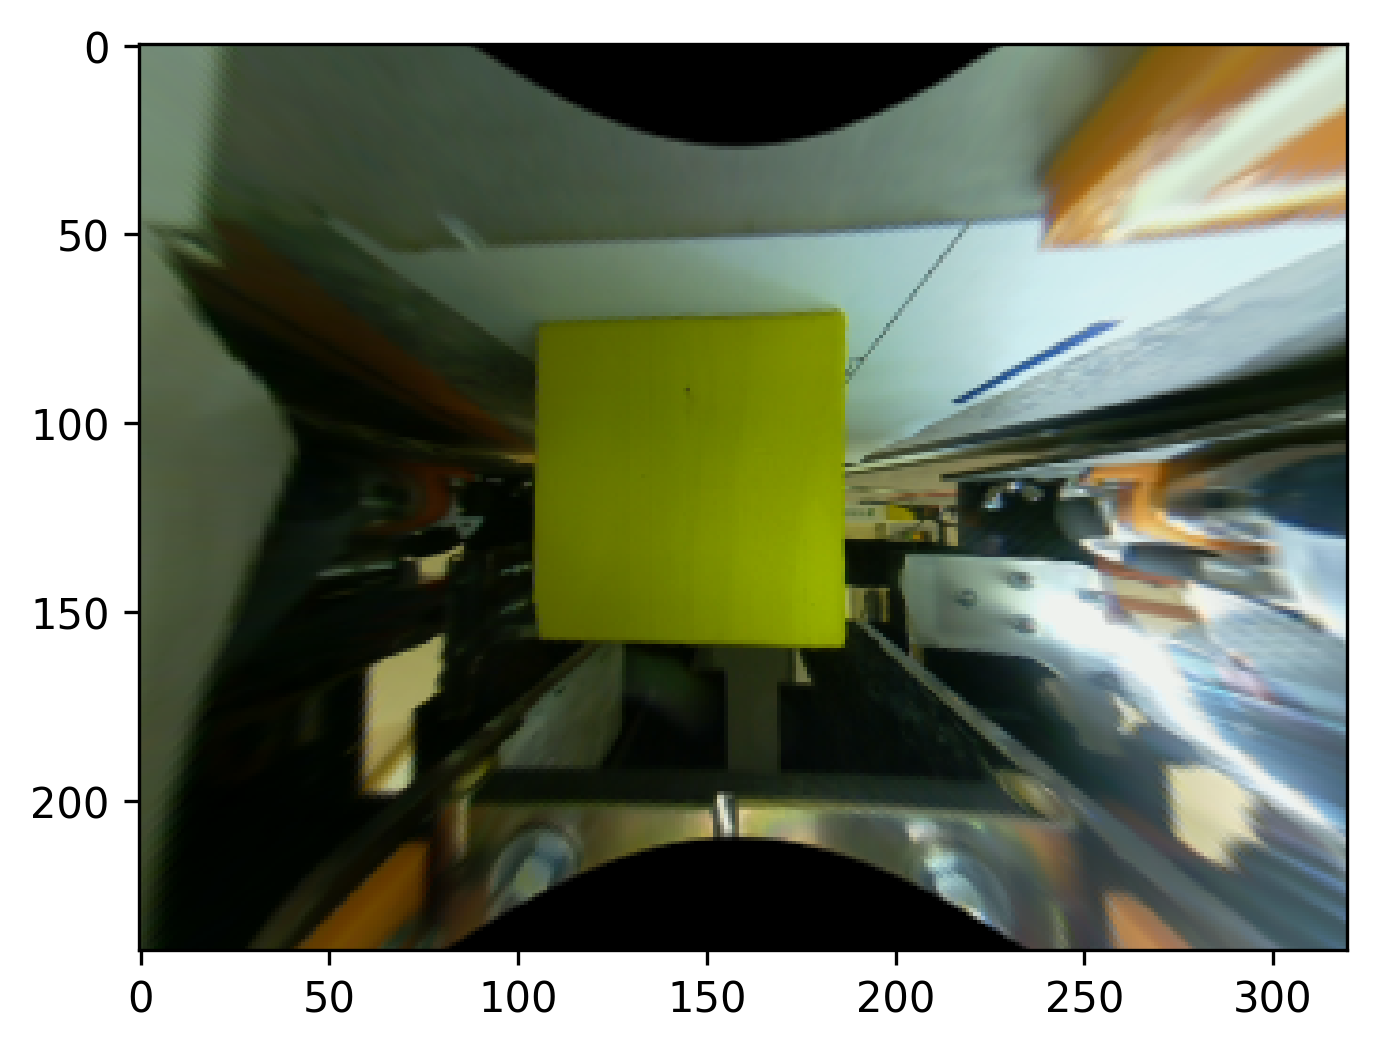

In [129]:
undisort_img = cv2.fisheye.undistortImage(raw_img, K1, D, Knew = K2)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(undisort_img);

# Smoothing

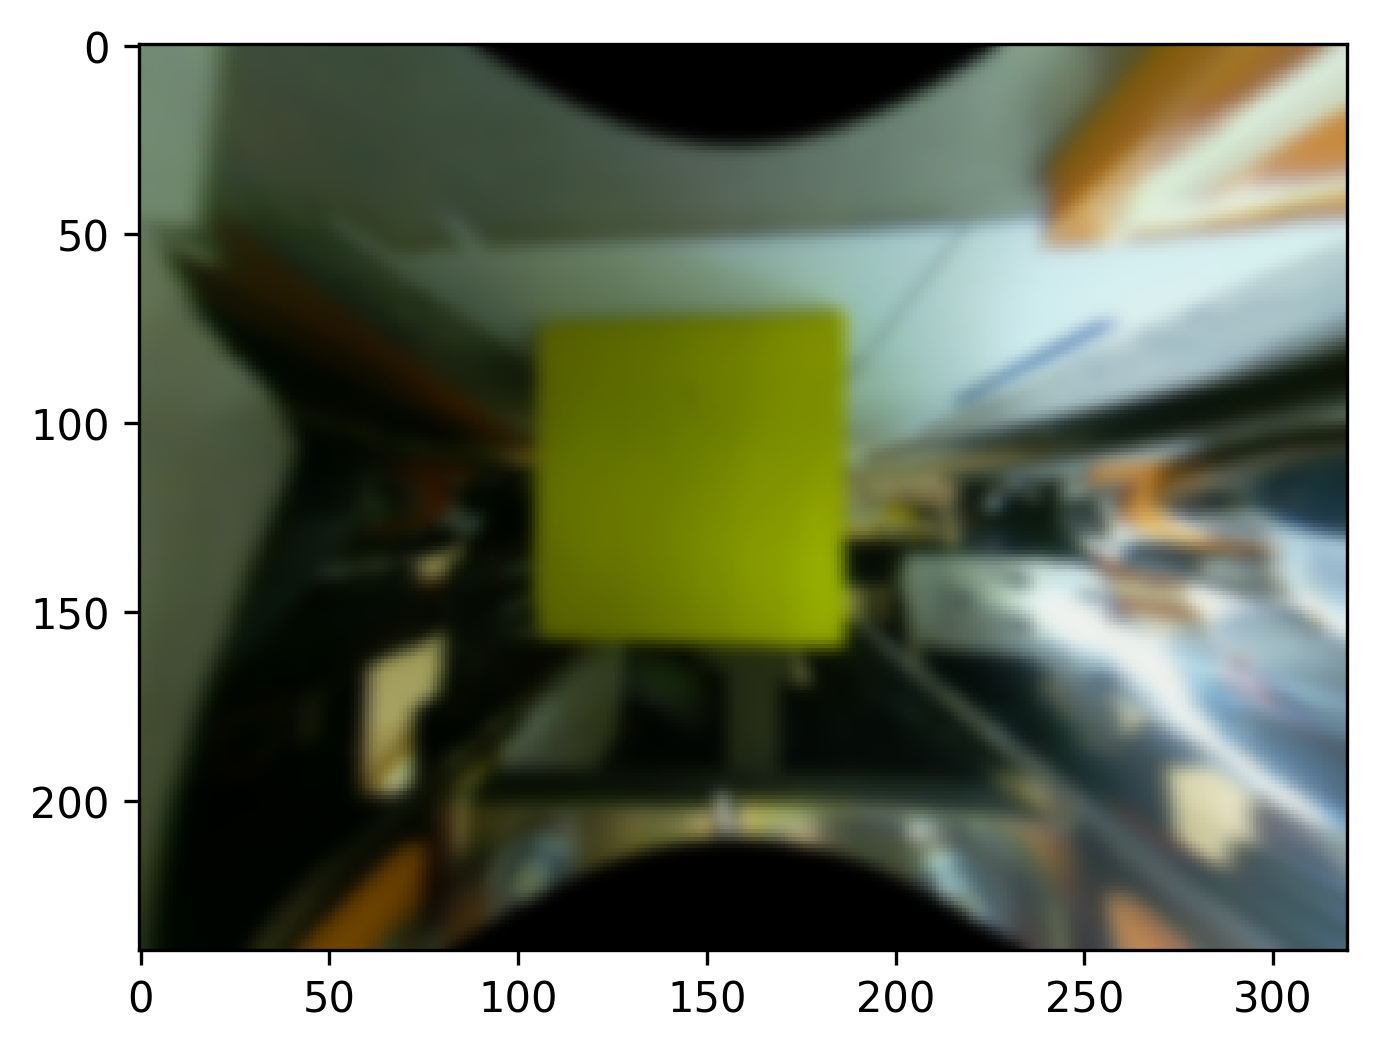

In [130]:
smooth_img = np.zeros_like(undisort_img, dtype=np.float32)
for c in range(3):
    smooth_img[:, :, c] = skimage.filters.gaussian(undisort_img[:, :, c], sigma=2)
smooth_img = (255 * smooth_img).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(smooth_img);

# Gradient

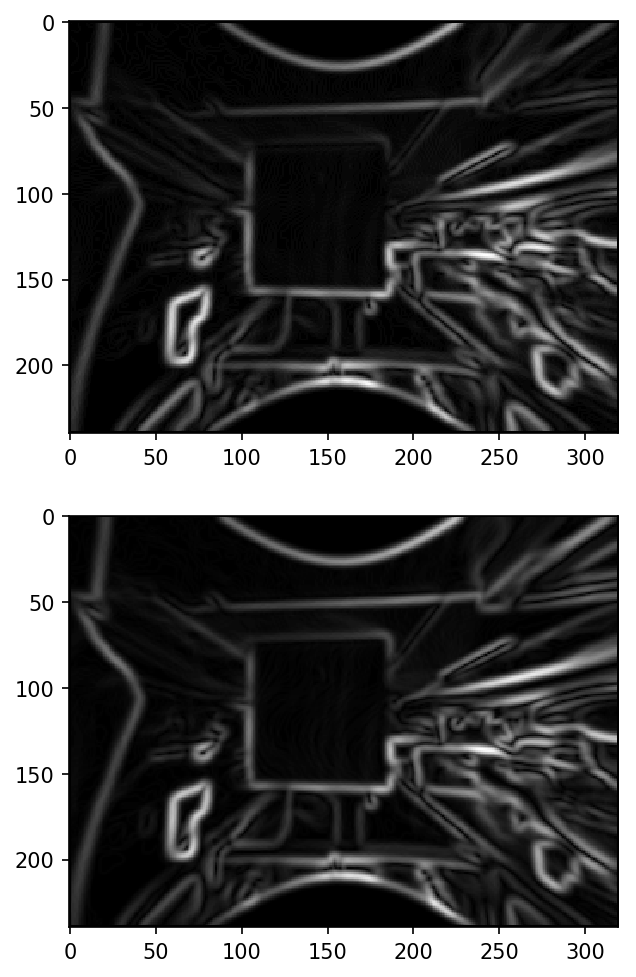

In [131]:
input_img = smooth_img.copy()
edge_roberts = skimage.filters.roberts(input_img[:, :, 0])
edge_sobel = skimage.filters.sobel(cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY))
fig, ax = plt.subplots(2, 1, figsize=(6, 8), dpi=150)
ax[0].imshow(edge_roberts, cmap="gray");
ax[1].imshow(edge_sobel, cmap="gray");

# Optimization

## Local search in gradient image (rectangle)

In [132]:
DIFF_IND = np.zeros((4, 4 * 4), dtype=np.int32)
for i in range(4):
    DIFF_IND[i, 3 * i: 3 * i + 3] = np.array([3, 2, 1])
    DIFF_IND[i, 3 * 4 + i] = -1

In [133]:
BETA = 20
@njit
def edge_cost_func(edge, params):
    N = (params[1] - params[0]) * (params[3] - params[2])
    n = np.sum(edge[params[0]:params[1], params[2]:params[3]])
    return N - n * BETA

@njit
def get_new_params(old_params, j, k):
    params = old_params.copy()
    params[j] -= (1 - 2 * (j % 2)) * k
    diff_params = old_params.copy()
    diff_params[2 * (j // 2)], diff_params[2 * (j // 2) + 1] =\
        min(old_params[j], params[j]), max(old_params[j], params[j]) 
    return diff_params, params
    
@njit
def local_search(init_params, edge):
    params = init_params.copy() 
    for i in range(200):
        f = False
        for k in [3, 2, 1, -1]:
            for j in range(4):
                diff_params, new_params = get_new_params(params, j, k)
                cost = edge_cost_func(edge, diff_params)
                if (k > 0 and cost > 0) or (k < 0 and cost < 0):
                    params = new_params
                    f = True
                    break
            if f:
                break
        if not f:
            break
    return params

CPU times: user 410 ms, sys: 4.41 ms, total: 414 ms
Wall time: 505 ms


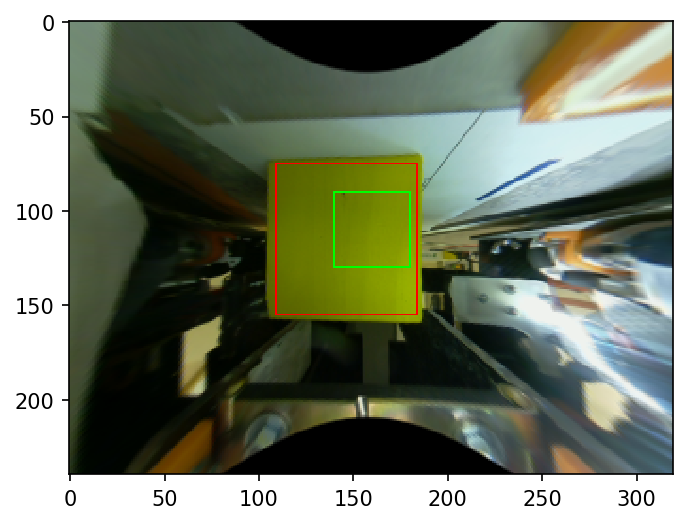

In [134]:
%%time
init_params = np.array([90, 130, 140, 180])
edge = 0
for c in range(3):
    edge = edge + skimage.filters.sobel(smooth_img[:, :, c])
params = local_search(init_params, edge)
input_img = undisort_img.copy()
cv2.rectangle(input_img, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
cv2.rectangle(input_img, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

### Many images

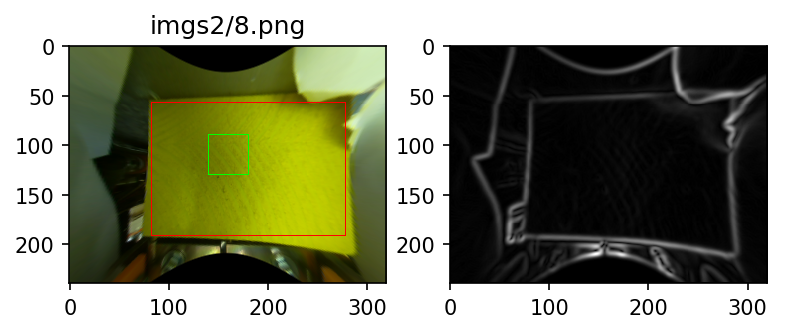

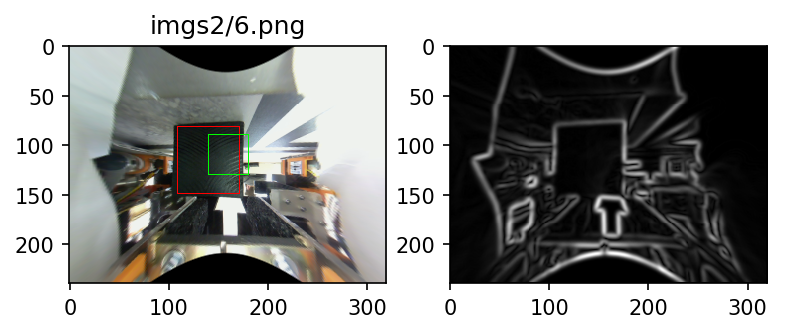

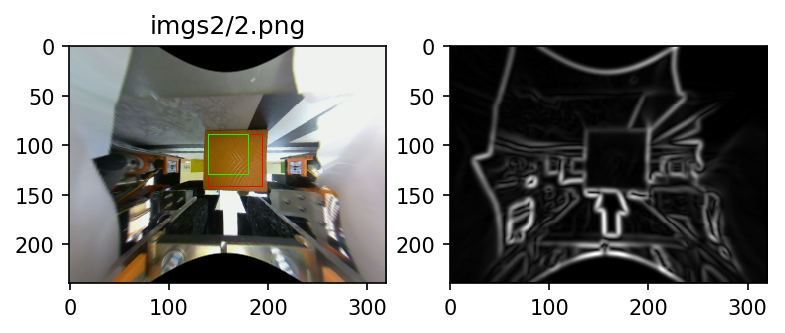

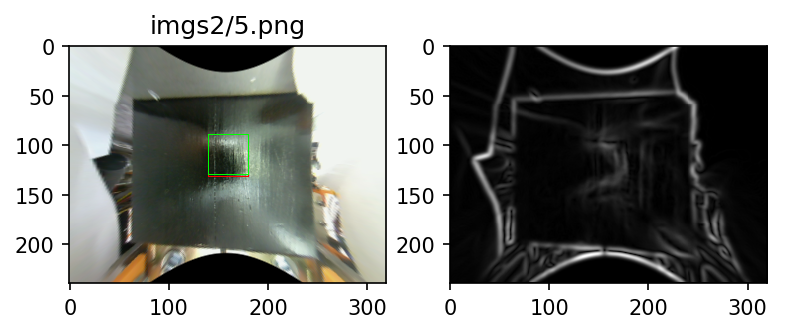

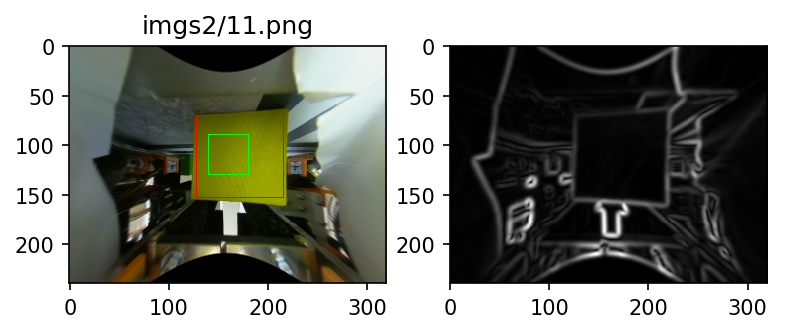

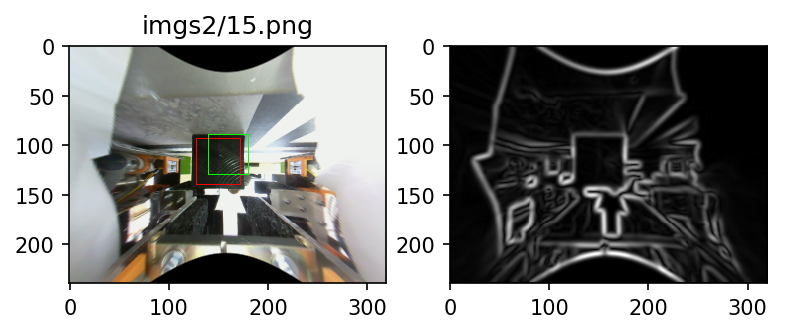

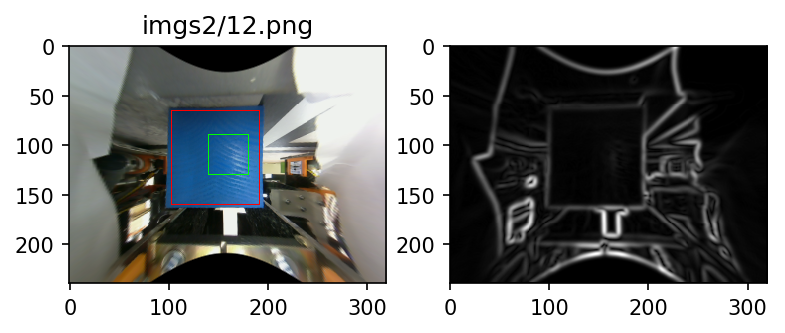

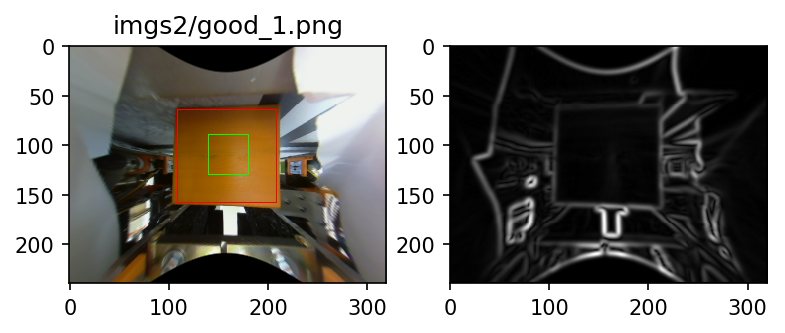

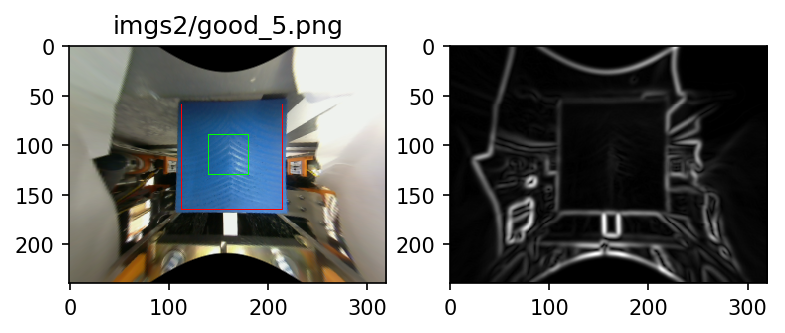

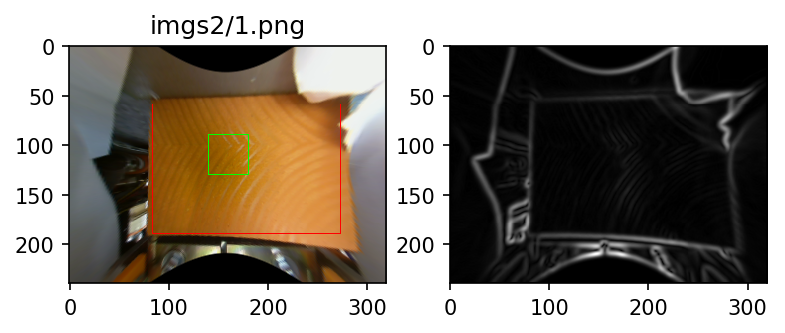

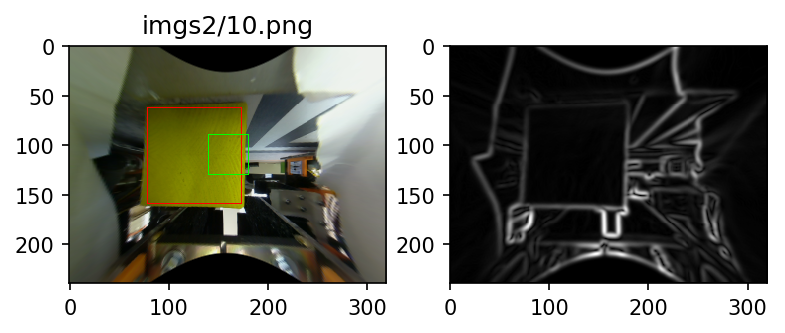

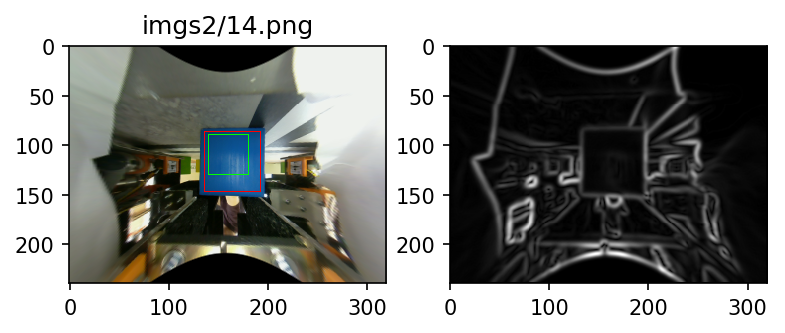

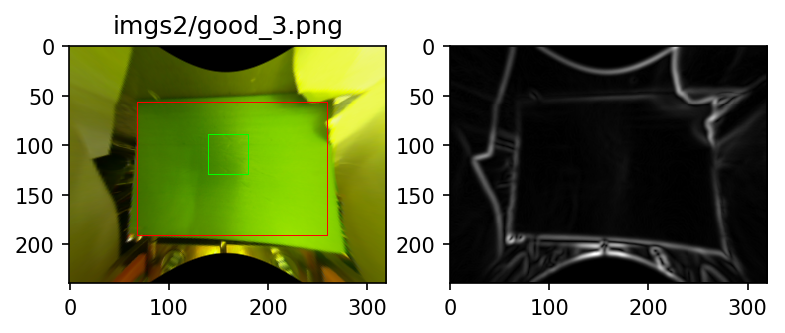

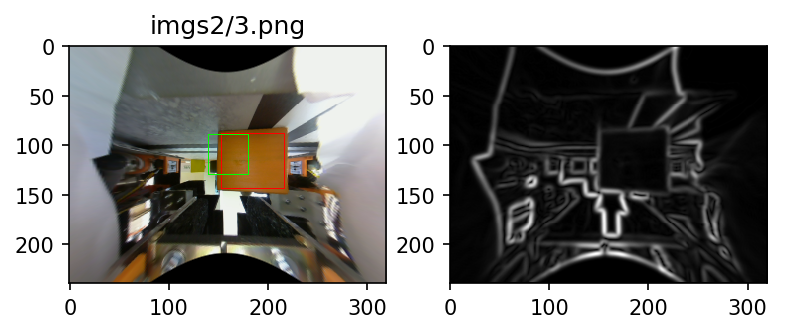

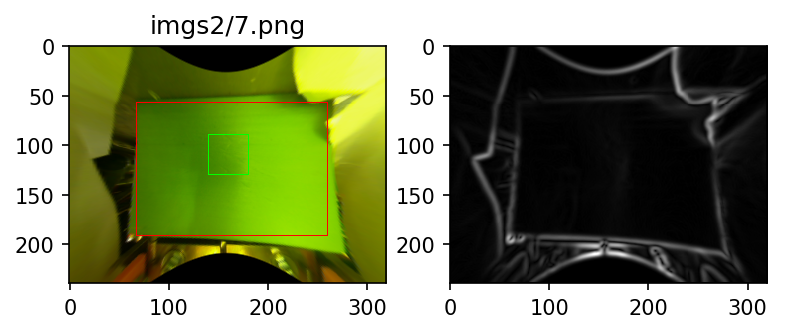

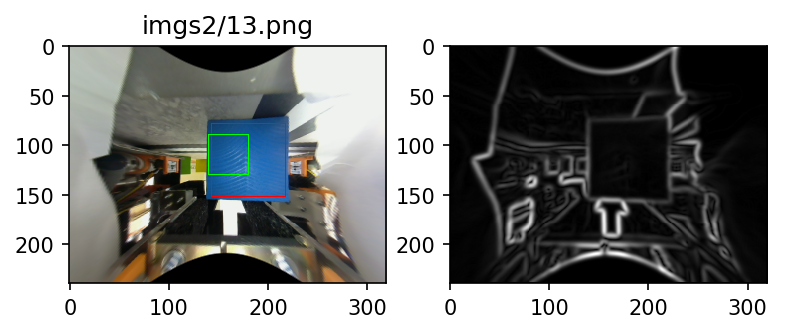

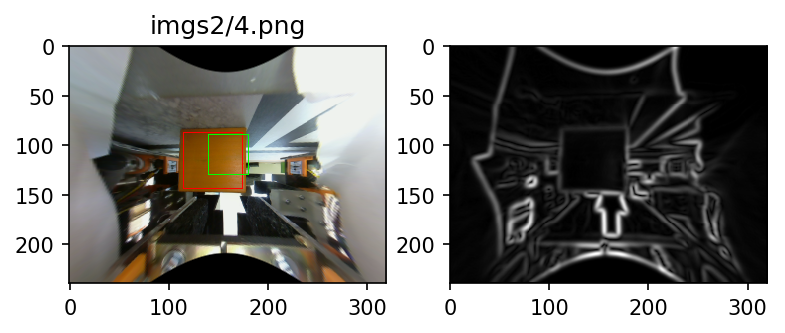

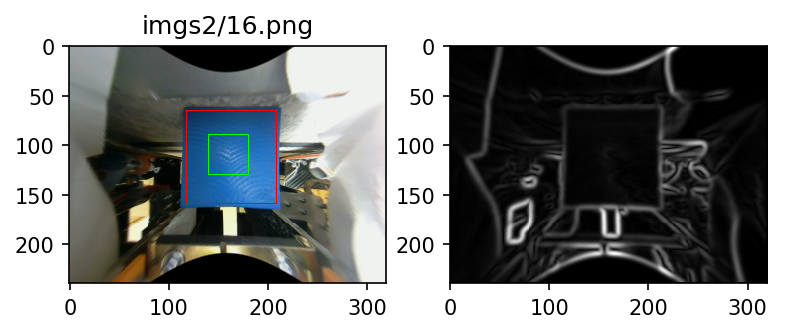

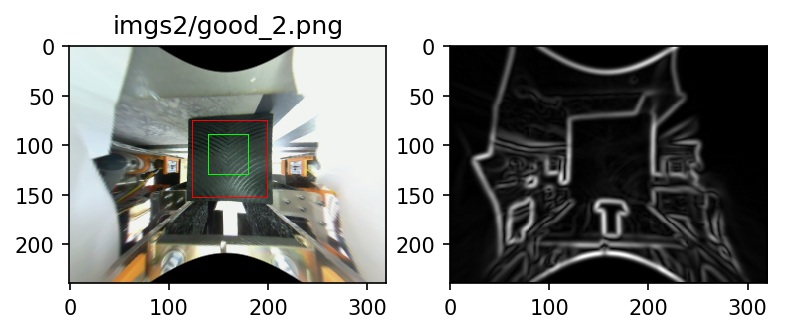

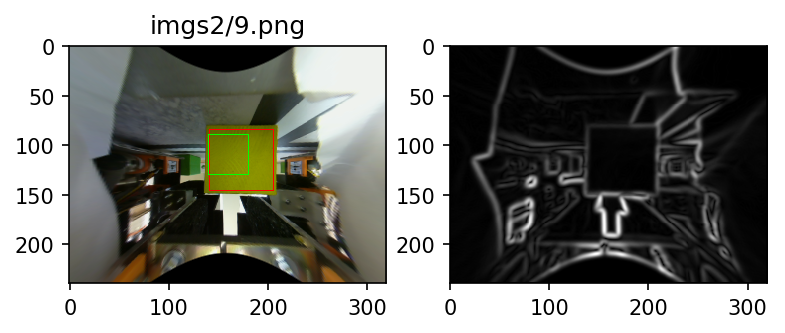

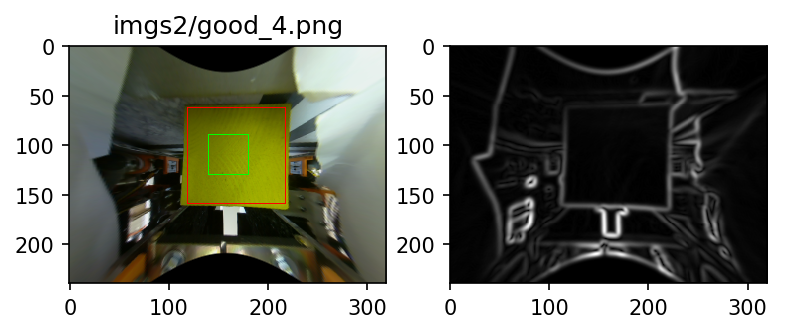

In [14]:
files = glob.glob("imgs2/*.png")
center = (160, 120)
for file in files:
    img1 = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img2 = cv2.fisheye.undistortImage(img1, K1, D, Knew = K2)
    
    img3 = np.zeros_like(undisort_img, dtype=np.float32)
    for c in range(3):
        img3[:, :, c] = skimage.filters.gaussian(img2[:, :, c], sigma=2)
    img3 = (255 * img3).astype(np.uint8)
    
#    edge = skimage.filters.sobel(cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY))
    edge = 0
    for c in range(3):
        edge = edge + skimage.filters.sobel(img3[:, :, c])
    init_params = np.array([90, 130, 140, 180])
    params = local_search(init_params, edge)
        
    cv2.rectangle(img2, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
    cv2.rectangle(img2, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
    fig, ax = plt.subplots(1, 2, figsize=(6, 4), dpi=150)
    ax[0].set_title(file)
    ax[0].imshow(img2)
    ax[1].imshow(edge, cmap="gray")
    plt.show()

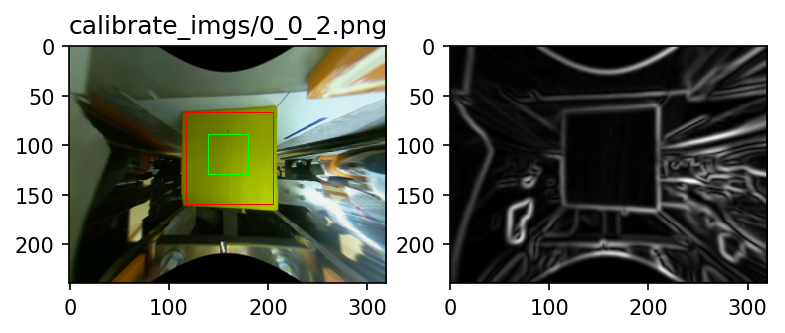

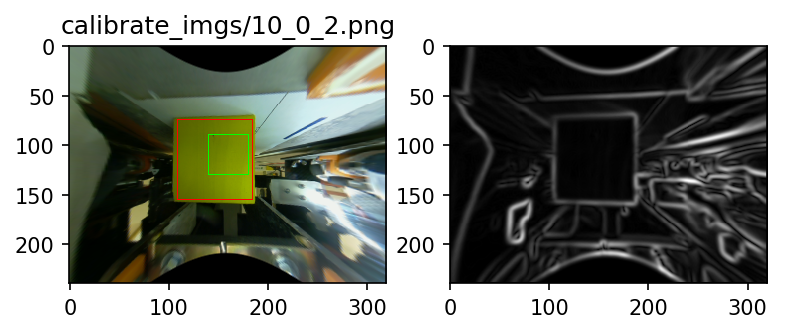

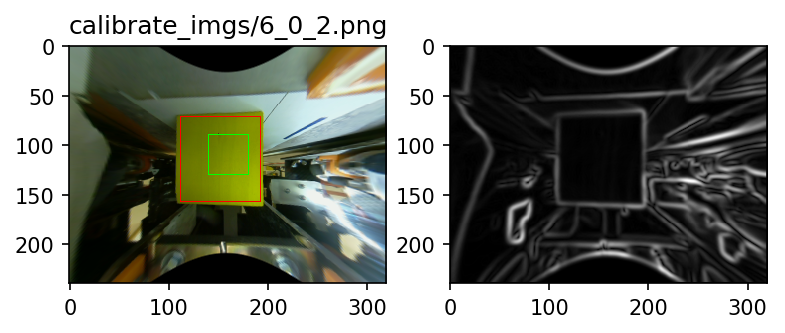

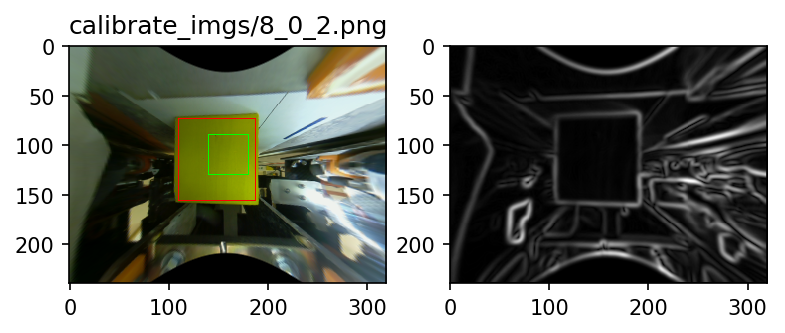

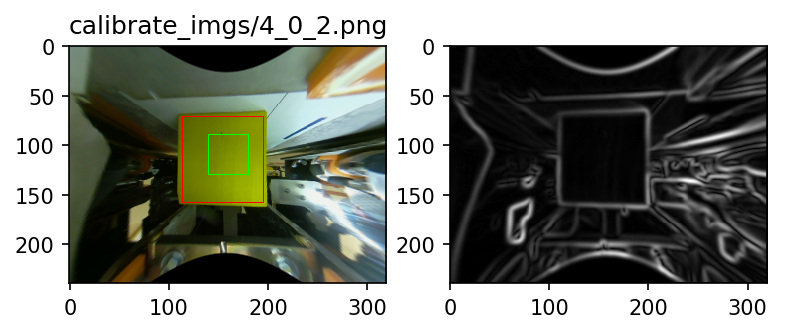

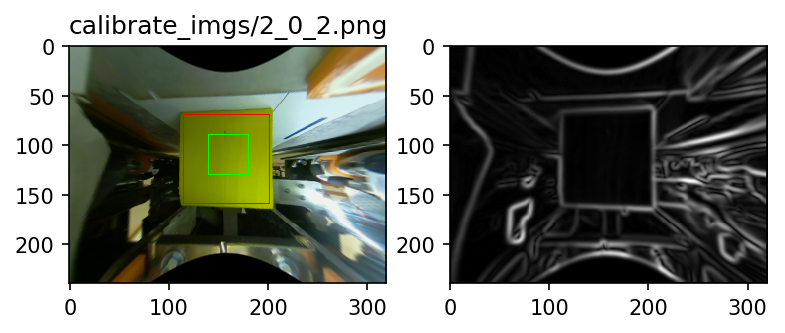

In [100]:
files = glob.glob("calibrate_imgs/*_0_2.png")
center = (160, 120)
ys = [int(re.match("\S+/(\d+)_\S+", file).group(1)) for file in files]
ps = []
for file in files:    
    img1 = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img2 = cv2.fisheye.undistortImage(img1, K1, D, Knew = K2)
    
    img3 = np.zeros_like(undisort_img, dtype=np.float32)
    for c in range(3):
        img3[:, :, c] = skimage.filters.gaussian(img2[:, :, c], sigma=2)
    img3 = (255 * img3).astype(np.uint8)
    
#    edge = skimage.filters.sobel(cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY))
    edge = 0
    for c in range(3):
        edge = edge + skimage.filters.sobel(img3[:, :, c])
    init_params = np.array([90, 130, 140, 180])
    params = local_search(init_params, edge)
    ps.append(params) 
    cv2.rectangle(img2, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
    cv2.rectangle(img2, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
    fig, ax = plt.subplots(1, 2, figsize=(6, 4), dpi=150)
    ax[0].set_title(file)
    ax[0].imshow(img2)
    ax[1].imshow(edge, cmap="gray")
    plt.show()

In [103]:
ys

[0, 10, 6, 8, 4, 2]

In [104]:
ps = np.array(ps)
ps

array([[ 68, 160, 118, 205],
       [ 75, 155, 109, 184],
       [ 72, 157, 112, 192],
       [ 74, 156, 110, 187],
       [ 72, 158, 114, 195],
       [ 70, 159, 115, 201]])

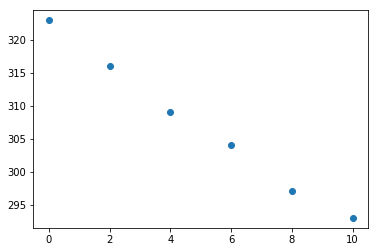

In [105]:
plt.scatter(ys, ps[:, 2] + ps[:, 3])

In [106]:
ys

[0, 10, 6, 8, 4, 2]

In [109]:
ps[0, 2] + ps[0, 3]

323

In [108]:
(ps[0, 2] + ps[0, 3] - ps[1, 2] - ps[1, 3]) / 10

3.0

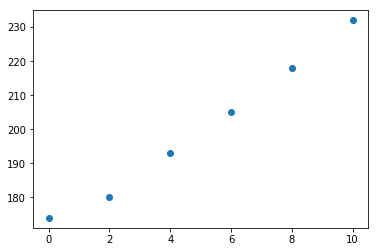

In [87]:
pss = ps[:, 1] - ps[:, 0] + ps[:, 3] - ps[:, 2]
plt.scatter(xs, pss)

In [91]:
pss[]

232

In [110]:
pss[4] - 6.5

173.5

In [93]:
(232 - 180) / 8

6.5

In [ ]:
ky = 6.5
kx = -3